# Решение задачи 2.3:


$cov(\frac{1}{M}\Sigma, \frac{1}{M}\Sigma) = \frac{1}{M^2}\sum cov(\xi_i, \xi_i) + \frac{1}{M^2}\sum \limits_{i \neq j} {cov(\xi_i, \xi_j)} = \frac{1}{M}\sigma^2 + \frac{M-1}{M}\rho\sigma^2 = \frac{1}{M}(1-\rho)\sigma^2 + \rho\sigma^2$

# Отчет о решении контеста

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from copy import deepcopy
%matplotlib inline

In [2]:
def smape(actual, predicted):
    return np.mean(np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted)) / 2)) * 100

In [3]:
data = pd.read_csv("train.tsv")
data.sort_values(['year', 'week'], inplace=True)

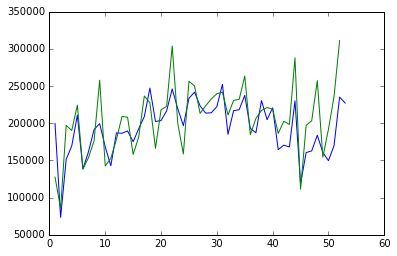

In [4]:
plt.plot(data[data.year == 2014].groupby('week')['y'].mean())
plt.plot(data[data.year == 2013].groupby('week')['y'].mean())

Первое, что я заметил, это то, что профит за 2013 год сильно кореллирует с профитом за 2014 год. Скорее всего он так же кореллирует с профитом за 2015 год. Отсюда я сделал предположение, что выручка за товар в прошлом году за ту же неделю может быть хорошей фичей для модели. Но мне это не помогло.

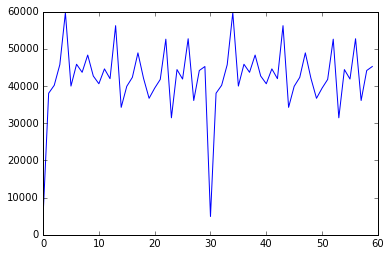

In [5]:
plt.plot(data.values[0][-60:])

Оказывается признак $f_i$ полностью совпадает с признаком $f_{i+30}$. Ну ок. Удалим последние 30 фичей

In [6]:
data.drop(data.columns[-30:], axis=1, inplace=True)

In [7]:
data[(data.year==2014) & (data.week.isin([4, 5, 6])) & (data['shift']==1) & (data.item_id==20442076)]

,Num,y,year,week,shift,item_id,f1,f2,f3,f4,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
38292,190342,77297,2014,4,1,20442076,52819.0,49869.0,50385.0,53714.0,...,51639.0,48881.0,55786.0,43154.0,50768.0,58915.0,73580.0,44640.0,27140.0,45519.0
38960,193661,75541,2014,5,1,20442076,49869.0,50385.0,53714.0,55420.0,...,48881.0,55786.0,43154.0,50768.0,58915.0,73580.0,44640.0,27140.0,45519.0,48011.0
39624,196971,64488,2014,6,1,20442076,50385.0,53714.0,55420.0,57300.0,...,55786.0,43154.0,50768.0,58915.0,73580.0,44640.0,27140.0,45519.0,48011.0,46920.0


Далее я заметил, что f признаки для текущей неделе это сдвинутые f признаки для предудущей недели. Я предположил, что $f_i$ это профит за какой-то промежуток времени какой-то из предыдущих недель. Решил проверить.

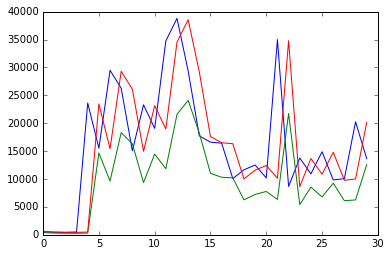

In [8]:
y = data[(data.item_id == 20442194) & (data['shift'] == 1) & (data.year == 2013)]['y'].values[-30:]
f = data[(data.item_id == 20442194) & (data['shift'] == 1) & (data.year == 2013) & (data.week==52)].values[0][-30:]
plt.plot(y)
plt.plot(f)
plt.plot(f * 1.6)

Оказывается, $f_i$ - прибыль за предыдущие недели деленная на 1.6. Этот факт позволяет получить точные значения прибыли для большинства товаров за 3юю и 4ую неделю 2015 года.

Отбор признаков для модели:<br>
1) Сам по себе item_id довольно бесполезный признак для модели. Как-то кластеризовать товары у меня не получилось. <br>
2) Num тоже бесполезен. <br>
3) В тестовой выборке все данные даны за 2015 год. В обучающей выборке таких данных почти нет. Так что year я тоже выкинул <br>
4) Кажется что week должен быть хорошим признаком. На локальном тесте он действительно дает буст. Но он ухудшает результат на leaderbord. Возможно у меня кривые руки.

Наиболее полезными фичами оказались $f_1 - f_{30}$. Однако, этих признаков слишком много и модель может переобучиться на них. Так что я удалил признаки $f_1 - f_{15}$ Это привело к уменьшению ошибки.

Также кажется логичным, оперировать не абсолютными значениями прибыли, а относительными. По этому я поделил $y$ и все $f_i$ на $f_{30}$. Это значительно улучшило качество модели

В качестве целевой функции я взял log(1 + y / $f_{30}$)

Я обучал модель на всех неделях кроме 1, 2, 51 и 52. Отбрасывание этих недель приводит к уменьшению ошибки.<br>
Также я отбросил те строчки где $y / f_{30} > 50$. Своеобразные выбросы.

In [9]:
X = data[data.columns.drop(['Num', 'y'])]
y = data['y']
f30 = deepcopy(X.f30)

In [10]:
f_cols = ['f' + str(i + 1) for i in range(15, 30)]
cols = f_cols
X = X[f30 > 0]
y = y[f30 > 0]
f30 = f30[f30 > 0]
for col in f_cols:
    X[col] = X[col] / f30
y = np.log(1 + y / f30)

In [11]:
def test(model):
    res = []
    for i in range(3, 50):
        X_test = X[(X.year == 2013) & (X['shift'] == 1) & (X.week==i)]
        y_test = y[(X.year == 2013) & (X['shift'] == 1) & (X.week==i)]
        X_test = X_test[cols]
        
        res.append(smape(np.exp(model.predict(X_test[cols])) - 1, np.exp(y_test) - 1))
    return np.mean(res)

In [12]:
X_train = X[(X['shift'] == 1) & (X.week >= 3) & (X.week <= 50) & (X.year==2014)]
y_train = y[(X['shift'] == 1) & (X.week >= 3) & (X.week <= 50) & (X.year==2014)]

X_test = X[(X['shift'] == 1) & (X.week >= 3) & (X.week <= 50) & (X.year==2013)]
y_test = y[(X['shift'] == 1) & (X.week >= 3) & (X.week <= 50) & (X.year==2013)]

X_train = X_train[cols]
X_train = X_train[y <= 50]
y_train = y_train[y <= 50]

/home/pavel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Я обучил 3 модели. Gradient Boosting, Random Forest и KNN. 

In [13]:
model1 = KNeighborsRegressor(30, p=1, weights='distance')
model2 = RandomForestRegressor(n_estimators=200, n_jobs=8)
model3 = XGBRegressor(n_estimators=50, max_depth=9, subsample=0.75, base_score=0)
model1.fit(X_train[cols], y_train)
model2.fit(X_train[cols], y_train)
model3.fit(X_train[cols], y_train)
print(test(model1))
print(test(model2))
print(test(model3))

23.0069280646
22.6020790079
23.0540499013


In [14]:
p1 = model1.predict(X_test[cols])
p2 = model2.predict(X_test[cols])
p3 = model3.predict(X_test[cols])

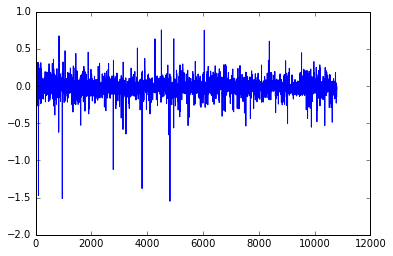

In [15]:
plt.plot(p1 - p2)

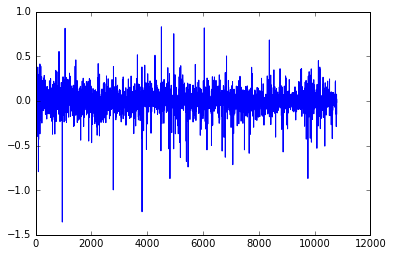

In [16]:
plt.plot(p1 - p3)

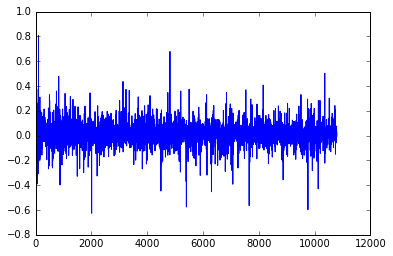

In [17]:
plt.plot(p2 - p3)

Выдаваемые ответы могут значительно различаться, так что я посчитал хорошей идеей усреднять предсказания моделей.

In [18]:
smape((np.exp(p1) - 1) * 0.33 + (np.exp(p2) - 1) * 0.33 + (np.exp(p3) - 1) * 0.33, np.exp(y_test) - 1)

22.307949432803625

In [22]:
X_train = X[(X['shift'] == 1) & (X.week >= 3) & (X.week <= 50) & ((X.year==2013) | (X.year==2014))]
y_train = y[(X['shift'] == 1) & (X.week >= 3) & (X.week <= 50) & ((X.year==2013) | (X.year==2014))]

X_train = X_train[cols]
X_train = X_train[y <= 50]
y_train = y_train[y <= 50]

model1 = KNeighborsRegressor(30, p=1, weights='distance')
model2 = RandomForestRegressor(n_estimators=200, n_jobs=8)
model3 = XGBRegressor(n_estimators=50, max_depth=9, subsample=0.75, base_score=0)

model1.fit(X_train[cols], y_train)
model2.fit(X_train[cols], y_train)
model3.fit(X_train[cols], y_train)

/home/pavel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


XGBRegressor(base_score=0, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=50, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.75)

In [36]:
test_data = pd.read_csv('test.tsv')

In [37]:
ans = {}
for index, record in test_data.iterrows():
    if record.week == 5:
        ans[(record.item_id, 3.0)] = record.f29 * 1.6
        ans[(record.item_id, 4.0)] = record.f30 * 1.6
    if record.week == 4:
        ans[(record.item_id, 3.0)] = record.f30 * 1.6

In [38]:
for index, record in test_data.iterrows():
    if (record.item_id, record.week) not in ans:
        if record['shift'] == 1:
            f30 = deepcopy(record.f30)
            if f30 == 0:
                ans[(record.item_id, record.week)] = 0
            else:
                record[f_cols] /= f30
                x = record[cols]
                p = np.mean([np.exp(model1.predict(pd.DataFrame([x], columns=cols))[0]) - 1,
                             np.exp(model2.predict(pd.DataFrame([x], columns=cols))[0]) - 1, 
                             np.exp(model3.predict(pd.DataFrame([x], columns=cols))[0]) - 1])
                ans[(record.item_id, record.week)] = f30 * p

In [39]:
y = []
for index, record in test_data.iterrows():
    if (record.item_id, record.week) in ans:
        y.append(ans[(record.item_id, record.week)])

In [40]:
res = pd.DataFrame(list(zip(test_data.Num.values, y)), columns=['Num', 'y'])

In [41]:
res.to_csv('ans.csv', index=False)